# Distance based Transition Matrix

In [1]:
import random

import numpy as np
import pandas as pd

In [2]:
# Input
data_file = "POPmusic.csv"

# Delimiter
data_file_delimiter = ','

# The max column count a line in the file could have
largest_column_count = 0

# Loop the data lines
with open(data_file, 'r') as temp_f:
    # Read the lines
    lines = temp_f.readlines()

    for l in lines:
        # Count the column count for the current line
        column_count = len(l.split(data_file_delimiter)) + 1

        # Set the new most column count
        largest_column_count = column_count if largest_column_count < column_count else largest_column_count

# Close file
temp_f.close()

# Generate column names (will be 0, 1, 2, ..., largest_column_count - 1)
column_names = [i for i in range(0, largest_column_count)]

# Read csv
df = pd.read_csv(data_file, header=None, delimiter=data_file_delimiter, names=column_names)
print(df)

      0    1     2     3    4      5       6      7      8      9    ...  468  \
0      E5  7.0  7.11  11.4  4.7    0.5     0.5    7.0     E5    7.0  ...  NaN   
1       4  7.0     7     2  2.7      7       4      2    4.9      0  ...  NaN   
2     7.0   E4    C4   2.7   B3     C4     0.5     E4     C4    2.7  ...  NaN   
3      C5  7.0    G4    D5   G4     E5     7.0     G4     D5     G4  ...  NaN   
4     7.0   C5    E5    C5   D5    2.7      D5     E5    4.9     A4  ...  NaN   
5      A4  0.5    A4    A4   A4     G4     7.0     C4    4.9     G3  ...  NaN   
6     4.9   E5   4.9    E5   D5      4     4.7     E5     D5      4  ...  NaN   
7      C5  0.5    C5    C5  9.2     A4      E5     D5     C5     B4  ...  NaN   
8     4.7  7.0    G3    E4   E4     E4      E4     D4     F4    9.2  ...  NaN   
9   0.4.7  7.0    G4    A4  7.0     E4  7.11.2    2.7     G4  0.2.7  ...  NaN   
10    7.0  4.9   9.0   0.5  7.0    0.4      C3     E3    7.0    4.9  ...  NaN   
11    9.2   G5    E5    G5  

In [3]:
# Function to generate a list of unique notes and chords from the dataframe
def unique(df):
    main_list = []
    for i in range(len(df)):
        tlist = df.iloc[i].to_list()  # a song is picked from dataframe
        cleaned_list = [x for x in tlist if str(x) != 'nan']  # removing nan values
        main_list += cleaned_list  # all songs joined into a single list
    main_list = [str(x) for x in main_list]  # converting some integers and floats to string
    return list(set(main_list))  # only unique chords and notes are returned

In [4]:
# Function returns a clean list
def clean(tlist):
    tlist = [str(x) for x in tlist]
    return [x for x in tlist if str(x) != 'nan']

In [5]:
unique_list = unique(df)
print(len(unique_list))

65


In [6]:
# Function to generate transition matrix
def trans_matrix_gen(tlist, df):
    trans_matrix = np.zeros((len(tlist), len(tlist)))
    # the average distance between all pssible combinations of unique notes and chords is found
    for l1 in tlist:
        for l2 in tlist:
            c = 0  # acts as a counter in how many songs a combination exists
            avg_dist_total = 0  # the average distace between two unique notes or chords over all songs where they are found
            for i in range(len(df)):
                pos2 = 0
                avg_dist = 0  # the average distace between two unique notes or chords over a song
                k = 0  # counter for number of times a distance is calculated
                song = clean(df.iloc[i].to_list())  # cleaning the song
                if l1 in song and l2 in song:
                    if l1 != l2:  # case for different notes or chords
                        c += 1  # since both are found we increase the presence counter
                        pos1 = np.where(np.array(song) == l1)[0]  # the array stores the indices where l1 is found
                        start = np.min(pos1) + 1  # we search for l2 after the minimum index of l1
                        while pos2 < len(
                                song):  # we break from the loop if the position for l2 reaches end of list or we are unable to find any more
                            try:
                                pos2 = song.index(l2, start)
                                x = pos2 - pos1
                                dist = np.min(np.where(x >= 0, x, np.inf))  # minimum positive distance is stored
                                avg_dist += dist  # for now we just add the distances
                                k += 1  # we increase the measurement couter
                            except ValueError:
                                break
                            # start position for next search is moved to just next to where we found l2
                            start = pos2
                            start += 1
                        if k != 0:
                            avg_dist = avg_dist / k  # average distance in a song
                        avg_dist_total += avg_dist  # for now we add the distance

                    else:  # case for same notes or chords
                        c += 1
                        pos1 = song.index(l1)
                        start = pos1 + 1
                        while pos1 < len(song) - 1 and pos2 < len(song):
                            try:
                                pos2 = song.index(l2, start)
                                dist = pos2 - pos1
                                avg_dist += dist
                                k += 1
                                pos1 = pos2  # if there are 3 times the same chord or note we want the distance between 1st and 2nd, and 2nd and 3rd
                            except ValueError:
                                break
                            start = pos2
                            start += 1
                        if k != 0:
                            avg_dist = avg_dist / k
                        avg_dist_total += avg_dist

            if c != 0:
                avg_dist_total = avg_dist_total / c  # average distance of a combination over all songs where they are bound
            if avg_dist_total != 0:
                trans_matrix[tlist.index(l1)][tlist.index(
                    l2)] = 1 / avg_dist_total  # 1/d is taken so higher distance gives lower transition probabilty

    for i in range(len(tlist)):
        trans_matrix[i] = trans_matrix[i] / np.sum(trans_matrix[i])  # dividing by sum to convert to probability
    return trans_matrix

In [7]:
transition_matrix = trans_matrix_gen(unique_list, df)

In [8]:
print(transition_matrix)

[[0.0102271  0.         0.0051449  ... 0.00866144 0.00528166 0.0258335 ]
 [0.         0.         0.13612946 ... 0.         0.         0.        ]
 [0.01931204 0.0077583  0.00714433 ... 0.01193964 0.01676765 0.00851196]
 ...
 [0.00591507 0.         0.00694713 ... 0.01104853 0.00857906 0.00618579]
 [0.00315457 0.         0.00812446 ... 0.00895791 0.01493938 0.00505008]
 [0.04094085 0.         0.01911242 ... 0.01583817 0.02226315 0.07671362]]


In [9]:
print(np.max(transition_matrix), np.min(transition_matrix))
print(np.sum(transition_matrix[12]))
print(np.max(transition_matrix[2]), np.min(transition_matrix[2]))

0.6567742523038305 0.0
1.0
0.07093298763127331 0.0


In [10]:
# Function to make music
def music_gen(tlist, trans_matrix, length):
    music = [random.choice(tlist)]  # first note or chord is randomly chosen from the unique_list
    c = 0
    while c < length:
        i = tlist.index(music[c])  # we find the index of current note or chord in unique_list
        music.append(random.choices(tlist, weights=list(trans_matrix[i]), k=1)[
                         0])  # the row in transition matrix corresponding to the index we found contains all the transition probabilities
        c += 1
    return music

In [11]:
print(music_gen(unique_list, transition_matrix, 1000))

['C3', 'B3', '4.7', 'C2', 'B3', 'F4', '0', '11', '10', '7.0', '5.7.0', '2.7', '5.9.0', '0.2.7', '4.9', 'B3', 'E4', '5.7', '5.11', '11.2', 'F5', '2.4.9', '5.9.0', '9.0.2', 'A5', '7.11', 'C3', 'B5', '0.4.7', 'E5', 'D6', '7.9', '0.5', '7.11', '9', '7', 'D5', '5.9.0', '5.7.0', '2.5.9', '2.5.9', '7.11', 'E2', 'B-3', 'F2', '5.9', 'F2', 'B-3', 'C2', '7.0', 'A4', 'B-5', 'G5', 'C3', '7.11', '5', '4', '2.5', '2.4', 'E4', 'D5', '11.2', '5.9.0', '2.7', '5.9.0', '5.7.0', '7.11', 'E2', '4.7', 'C2', 'F2', 'F5', '11.4', '5.9', 'F2', '7.11', '7.9', 'A4', '11.2', '0', '0', '10', '11.4', '7.0', '2.4', 'E4', '5.7', '5.11', '0.5', '0', '9', '7', '11', '11.4', 'E5', '5.7.0', 'F4', '0', '9', '5', '4.7', '7.9', 'A5', 'G5', '7.9', '9.2', 'B5', 'D5', 'C3', 'G5', 'C6', 'E6', 'C5', '5.9.0', 'F4', 'G3', '2.5', 'C5', '7.11.2', '11.2', '2.4.9', '5.9.0', 'G5', '4.9', 'B3', '7.11', '2.5', '9.0', 'C3', 'B3', 'A3', 'A3', 'E3', 'G5', 'B-5', 'C5', '9', '10', '11.4', '2.7', '0.2.7', '5.9.0', '0.2.7', '2.5.9', '4.7', 'C2', 

In [12]:
num_songs = 5
songs = []

# A bunch of songs are created and put into a dataframe
for _ in range(num_songs):
    songs.append(music_gen(unique_list, transition_matrix, 200))
df2 = pd.DataFrame(songs)
print(df2)
df2.to_csv("dist_method_songs.csv")

   0    1    2      3    4     5      6    7     8     9    ...   191    192  \
0   G3  0.5  2.7     B3  4.7    C2   7.11   C3  7.11     7  ...    C4  5.9.0   
1   B3  4.7   C3   7.11   E2   4.9      9   G5   9.2  11.2  ...    F4      0   
2  7.9   G5   A5  9.0.4  9.0  11.2  2.4.9   E5    G4    B3  ...    D6    0.2   
3  B-5   G5   C5    9.0   B5   4.9     F5  0.2  11.4   7.9  ...    C5  5.7.0   
4   G4   G5   D6    7.0    5   2.5      5    4   4.7   B-3  ...  11.2  5.9.0   

   193  194    195  196  197  198   199    200  
0  9.2   B5     F5   E5  4.7   C4    F3     E3  
1   11  2.5     G3   F3   E3   C6    E6    E-5  
2   E5   D5  9.0.2  4.7   C2  B-3    B3     C2  
3   F4  9.0     C5   G4    4    0   2.5     G3  
4   B4    0     F4  5.7   C4  5.7  11.2  2.4.9  

[5 rows x 201 columns]


# Stationary States

In [13]:
import random
import matplotlib.pyplot as plt

In [14]:
P = transition_matrix
stateChangeHist= np.zeros((P.shape))
state=np.zeros((1,len(P)))
state[0][0] = 1.0
currentState=0
stateHist=state
dfStateHist=pd.DataFrame(state)
distr_hist = np.zeros((1,len(P)))

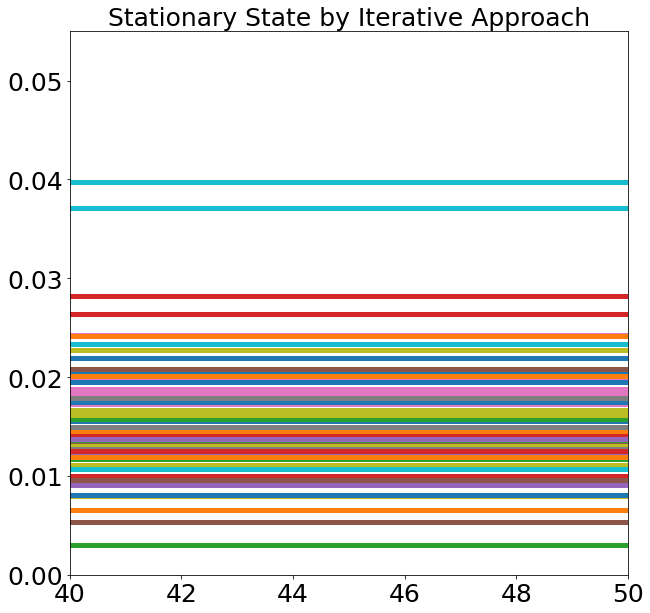

In [15]:
for x in range(50):
    state=np.dot(state,P)
    stateHist=np.append(stateHist,state,axis=0)
    dfDistrHist = pd.DataFrame(stateHist)
dfDistrHist.plot(legend=False, figsize=(10,10), linewidth=5)
plt.xlim((40,50))
plt.ylim((0,0.055))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title(label="Stationary State by Iterative Approach", fontsize=25)
plt.savefig("Iterative.png", dpi=600)
plt.show()

In [16]:
# Simulate from multinomial distribution
def simulate_multinomial(vmultinomial):
    r=np.random.uniform(0.0, 1.0)
    CS=np.cumsum(vmultinomial)
    CS=np.insert(CS,0,0)
    m=(np.where(CS<r))[0]
    nextState=m[len(m)-1]
    return nextState

In [17]:
for x in range(1000):
    currentRow=np.ma.masked_values((P[currentState]), 0.0)
    nextState=simulate_multinomial(currentRow)

    # Keep track of state changes
    stateChangeHist[currentState,nextState]+=1

    # Keep track of the state vector itself
    state=np.zeros((1,len(P)))
    state[0,nextState]=1.0

    # Keep track of state history
    stateHist=np.append(stateHist,state,axis=0)
    currentState=nextState
    
    # calculate the actual distribution over the states so far
    totals=np.sum(stateHist,axis=0)
    gt=np.sum(totals)
    distrib=totals/gt
    distrib=np.reshape(distrib,(1,len(P)))
    distr_hist=np.append(distr_hist,distrib,axis=0)
    
print(distrib)

[[0.02383645 0.01077556 0.01020011 0.00816209 0.01111047 0.00994257
  0.02320528 0.01306488 0.02100935 0.01008111 0.01974183 0.01093087
  0.00489399 0.00806192 0.02376697 0.00827528 0.01510025 0.00824927
  0.00614233 0.00615189 0.00703161 0.01113158 0.02271479 0.0335732
  0.00622638 0.01426677 0.01030607 0.01675157 0.01694444 0.02400379
  0.00995189 0.03258794 0.00622808 0.00914221 0.00913611 0.00805765
  0.01612273 0.01390132 0.01382442 0.04180989 0.01696645 0.01397986
  0.00911438 0.01584138 0.01012312 0.00310155 0.01303131 0.01881141
  0.01395695 0.04475983 0.024906   0.00910336 0.0121482  0.02710143
  0.00897662 0.00729343 0.0313132  0.01794867 0.01121844 0.01191516
  0.02183155 0.02774393 0.01587099 0.01493239 0.02159545]]


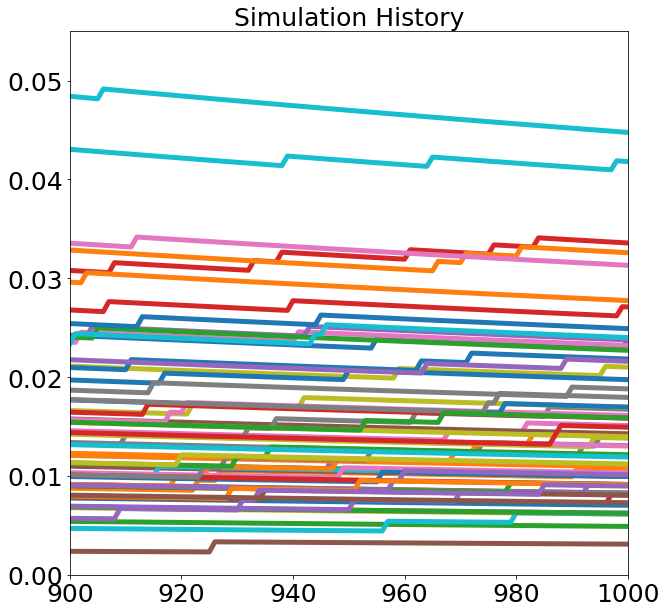

In [18]:
P_hat=stateChangeHist/stateChangeHist.sum(axis=1)[:,None]

# Check estimated state transition probabilities based on history so far:
dfDistrHist = pd.DataFrame(distr_hist)

# Plot the distribution as the simulation progresses over time
dfDistrHist.plot(legend=False, figsize=(10,10), linewidth=5)
plt.xlim((900,1000))
plt.ylim((0,0.055))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title(label="Simulation History", fontsize=25)
plt.savefig("Simulation.png",dpi=600)
plt.show()

# K-Means Clustering

In [19]:
from statistics import mean

In [20]:
X=[]
for l in unique_list:
    freq = []
    avg_pos = []
    for i in range(len(df)):
        song = clean(df.iloc[i].to_list())
        freq.append(song.count(l))
        indices = [j for j, x in enumerate(song) if x == l]
        if len(indices) != 0:
            avg_pos.append(mean(indices))
    X.append([mean(avg_pos),mean(freq)])
print(X)

[[159.24708624708626, 2.55], [111, 0.05], [128.62772839577113, 15.15], [68.425, 0.65], [136.43333333333334, 3.25], [99, 0.2], [109.878125, 1.5], [113.92857142857143, 2.05], [47.583333333333336, 0.25], [92.125, 0.45], [80, 0.05], [114.1010101010101, 0.75], [129, 0.3], [125.25, 0.2], [144.05, 0.7], [108.85416666666667, 2.05], [144.41666666666666, 0.4], [87.83333333333333, 0.3], [117, 0.15], [79, 0.05], [146.67619047619047, 1.4], [126.39463364293086, 5.35], [29.5, 0.1], [74.53, 3.4], [81.53333333333333, 0.4], [78.5, 0.1], [134.25, 0.15], [35, 0.05], [117.49086403792286, 11.3], [76.36666666666667, 0.65], [173.45027341079972, 4.25], [121.13888888888889, 1.45], [14, 0.05], [136.91407056046748, 25.35], [139.92372387808902, 29.45], [70.18055555555556, 2.05], [118.92708333333333, 1.55], [127.83323457286536, 42.05], [124.5, 0.1], [83.64583333333333, 1.65], [85.5, 0.1], [213, 0.05], [123.2591930937762, 11.7], [166, 0.25], [78.25, 0.15], [83.5, 0.2], [161.07142857142858, 0.4], [168.35416666666666,

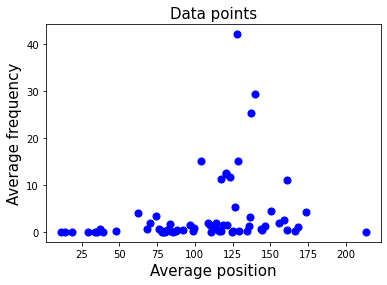

In [21]:
X = np.array(X)
plt.scatter(X[:, 0],X[:, 1], s=50, color ="b")
plt.xlabel("Average position", fontsize=15)
plt.ylabel("Average frequency", fontsize=15)
plt.title("Data points", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("Unclustered.png", dpi=600)
plt.show()

In [22]:
class K_means:
    def __init__(self,k=2,tol=0.001,max_iter=300):
        self.k =k
        self.tol =tol
        self.max_iter = max_iter
        self.centroids={}
        self.classifications={}
    
    def fit(self,data):
        for i in range(self.k):
            self.centroids[i] = data[i]
        for i in range(self.max_iter):
            for i in range(self.k):
                self.classifications[i] = []
            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)
                
            prev_centroids = dict(self.centroids) 
            #due to inheritance if we just set prev_centroids = self.centroids it will always change the prev_centroids
            #even if we explicitely change self.centroids
            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)
            optimized = True
            for i in range(self.k):
                original_centroid = prev_centroids[i]
                current_centroid = self.centroids[i]
                if np.sum((current_centroid-original_centroid)/original_centroid) > self.tol:
                    optimized = False
            
            if optimized:
                break
                
            
    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

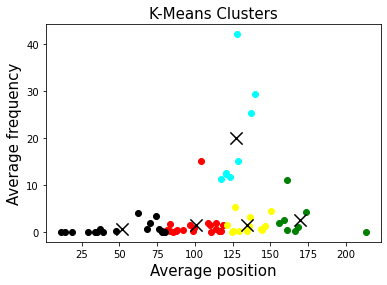

In [23]:
clf = K_means(k=5)
clf.fit(X)

colors = ["green","red","cyan","black","yellow","blue"]

for centroid in clf.centroids:
    plt.scatter(clf.centroids[centroid][0],clf.centroids[centroid][1], marker="x", color="k", s=150, zorder = 10)
    
for classification in clf.classifications:
    for featureset in clf.classifications[classification]:
        plt.scatter(featureset[0],featureset[1],color = colors[classification])

plt.xlabel("Average position", fontsize=15)
plt.ylabel("Average frequency", fontsize=15)
plt.title("K-Means Clusters", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("Clustered.png", dpi=600)       
plt.show()

# Ergodicity

In [24]:
def isAllNonZero(mat):
    for i in mat.flatten():
        if i==0:
            return False
    return True
    
def getNForErgodic(transitionMatrix, maxIter = 100):
    temp = np.identity(len(transitionMatrix))
    for i in range(1, maxIter+1):
        temp = np.dot(temp,transitionMatrix)
        if isAllNonZero(temp):
            return i
    print("Couldn't find n till", maxIter)
    return None

In [25]:
print(getNForErgodic(transition_matrix))

3
